The Benjamini Yakutieli (BY) procedure is a multiple testing procedure that can be used to control the accumulation in type 1 errors when comparing multiple hypothesis at the same time.

In the tsfresh filtering the BY procedure is used to decide which features to use and which to keep. 

The method is based on a line, the so called rejection line, that is compared to the sequence of ordered p-values. In this notebook, we will visualize that rejection line.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import defaults, extract_features
from tsfresh.feature_selection.feature_selector import check_fs_sig_bh
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

matplotlib.rcParams["figure.figsize"] = [16, 6]
matplotlib.rcParams["font.size"] = 14
matplotlib.style.use('seaborn-darkgrid')

/Users/mchrist/Documents/Research/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Parameter setting

In [2]:
FDR_LEVEL = defaults.FDR_LEVEL
HYPOTHESES_INDEPENDENT = defaults.HYPOTHESES_INDEPENDENT

## Load robot data

In [3]:
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


## Extract Features

In [4]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=ComprehensiveFCParameters(),
                     impute_function=impute)

Feature Extraction: 100%|██████████| 528/528 [00:26<00:00, 20.10it/s]
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'F_x__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"' ...,
 'T_z__fft_coefficient__coeff_9__attr_"imag"'
 'T_z__fft_coefficient__coeff_9__attr_"real"'
 'T_z__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [5]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(88, 4728)
(88, 1921)


## Calculate p-values and Benjamini-Yekutieli Procedure

tsfresh has implemented two different feature significance tests, the Mann-Whitney-U test and the Kolmogorov-Smirnov test. In the following, both of them are being illustrated to show a scientific report of the feature selection process and to give a comparison of the differences of both methods.

### Mann-Whitney-U
Run significance test with Mann-Whitney-U test. Returns the p-values of the features and whether they are rejected or not.

In [6]:
df_pvalues_mann = check_fs_sig_bh(X, y, fdr_level=FDR_LEVEL, test_for_binary_target_real_feature='mann')

In [7]:
print("# total \t", len(df_pvalues_mann))
print("# relevant \t", (df_pvalues_mann["rejected"] == True).sum())
print("# irrelevant \t", (df_pvalues_mann["rejected"] == False).sum(),
      "( # constant", (df_pvalues_mann["type"] == "const").sum(), ")")

('# total \t', 1921)
('# relevant \t', 595)
('# irrelevant \t', 1326, '( # constant', 0, ')')


In [8]:
df_pvalues_mann.head()

,Feature,rejected,type,p_value
Feature,,,,
F_x__abs_energy,F_x__abs_energy,True,real,5.900086e-12
F_x__range_count__max_1__min_-1,F_x__range_count__max_1__min_-1,True,real,6.268453e-12
F_y__abs_energy,F_y__abs_energy,True,real,6.327674e-12
T_y__variance,T_y__variance,True,real,6.778390e-12
T_y__standard_deviation,T_y__standard_deviation,True,real,6.778390e-12


### Kolmogorov-Smirnov
Run significance test with Kolmogorov-Smirnov test. Returns the p-values of the features and whether they are rejected or not.

In [9]:
df_pvalues_smir = check_fs_sig_bh(X, y, fdr_level=FDR_LEVEL, test_for_binary_target_real_feature='smir')

In [10]:
print("# total \t", len(df_pvalues_smir))
print("# relevant \t", (df_pvalues_smir["rejected"] == True).sum())
print("# irrelevant \t", (df_pvalues_smir["rejected"] == False).sum(),
      "( # constant", (df_pvalues_smir["type"] == "const").sum(), ")")

('# total \t', 1921)
('# relevant \t', 1058)
('# irrelevant \t', 863, '( # constant', 0, ')')


In [11]:
df_pvalues_smir.head()

,Feature,rejected,type,p_value
Feature,,,,
F_x__abs_energy,F_x__abs_energy,True,real,2.343896e-15
T_y__variance,T_y__variance,True,real,6.491072e-15
F_y__abs_energy,F_y__abs_energy,True,real,6.491072e-15
F_x__standard_deviation,F_x__standard_deviation,True,real,6.491072e-15
T_y__standard_deviation,T_y__standard_deviation,True,real,6.491072e-15


## Calculate rejection line
With the rejection line it is determined whether a feature is relevant or irrelevant.

### Mann-Whitney-U

In [12]:
m = len(df_pvalues_mann.loc[~(df_pvalues_mann.type == "const")])
K = list(range(1, m + 1))

if HYPOTHESES_INDEPENDENT:
    C = [1] * m
else:
    C = [sum([1.0 / i for i in range(1, k + 1)]) for k in K]

rejection_line_mann = [FDR_LEVEL * k / m * 1.0 / c for k, c in zip(K, C)]

### Kolmogorov-Smirnov

In [13]:
m = len(df_pvalues_smir.loc[~(df_pvalues_smir.type == "const")])
K = list(range(1, m + 1))

if HYPOTHESES_INDEPENDENT:
    C = [1] * m
else:
    C = [sum([1.0 / i for i in range(1, k + 1)]) for k in K]

rejection_line_smir = [FDR_LEVEL * k / m * 1.0 / c for k, c in zip(K, C)]

## Plot ordered p-values and rejection line

In the plot, the p-values are ordered from low to high. Constant features (green points) are always irrelevant but are not considered for calculating the rejection line (red line).

For nice plotting, the p-values are divided in the three groups relevant, irrelevant and constant (which are also irrelevant).

### Mann-Whitney-U

[]

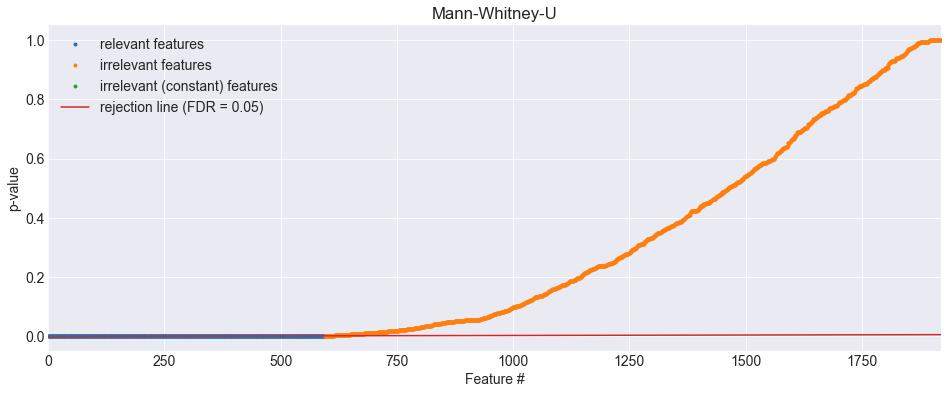

In [14]:
df_pvalues_mann.index = pd.Series(range(0, len(df_pvalues_mann.index)))

df_pvalues_mann.p_value.where(df_pvalues_mann.rejected)\
    .plot(style=".", label="relevant features")

df_pvalues_mann.p_value.where(~df_pvalues_mann.rejected & (df_pvalues_mann.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_mann.p_value.fillna(1).where(df_pvalues_mann.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.plot(rejection_line_mann, label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Mann-Whitney-U")
plt.legend()
plt.plot()

### Kolmogorov-Smirnov

[]

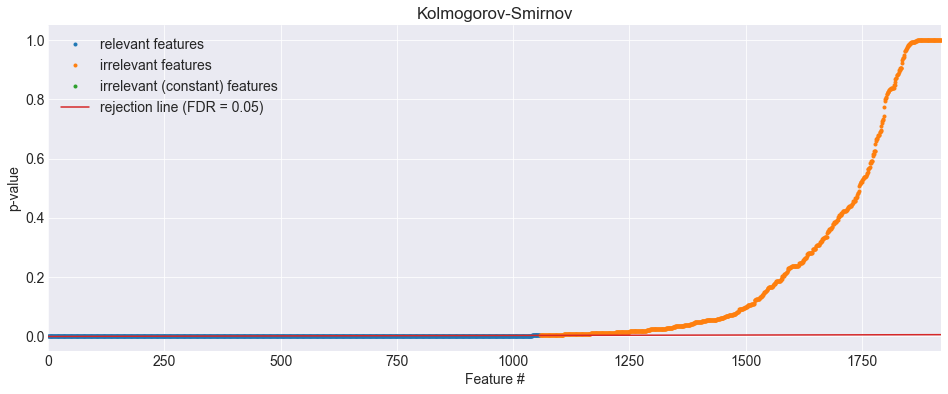

In [15]:
df_pvalues_smir.index = pd.Series(range(0, len(df_pvalues_smir.index)))

df_pvalues_smir.p_value.where(df_pvalues_smir.rejected)\
    .plot(style=".", label="relevant features")

df_pvalues_smir.p_value.where(~df_pvalues_smir.rejected & (df_pvalues_smir.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_smir.p_value.fillna(1).where(df_pvalues_smir.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.plot(rejection_line_smir, label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Kolmogorov-Smirnov")
plt.legend()
plt.plot()

## Plot zoomed ordered p-values and rejection line
Since the intersection of the ordered p-values and the rejection line is not clearly visible, a zoomed plot is provided.

### Mann-Whitney-U

[]

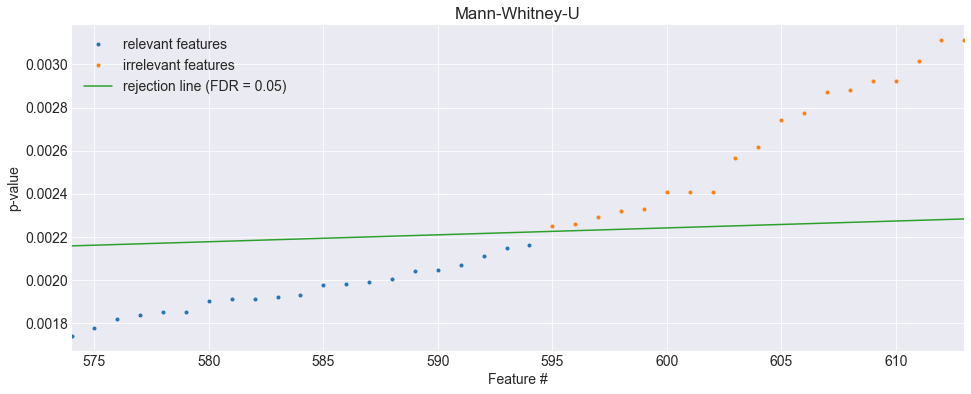

In [16]:
last_rejected_index = (df_pvalues_mann["rejected"] == True).sum() - 1
margin = 20
a = max(last_rejected_index - margin, 0)
b = min(last_rejected_index + margin, len(df_pvalues_mann) - 1)

df_pvalues_mann[a:b].p_value.where(df_pvalues_mann[a:b].rejected)\
    .plot(style=".", label="relevant features")
df_pvalues_mann[a:b].p_value.where(~df_pvalues_mann[a:b].rejected)\
    .plot(style=".", label="irrelevant features")
plt.plot(np.arange(a, b), rejection_line_mann[a:b], label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Mann-Whitney-U")
plt.legend()
plt.plot()

### Kolmogorov-Smirnov

[]

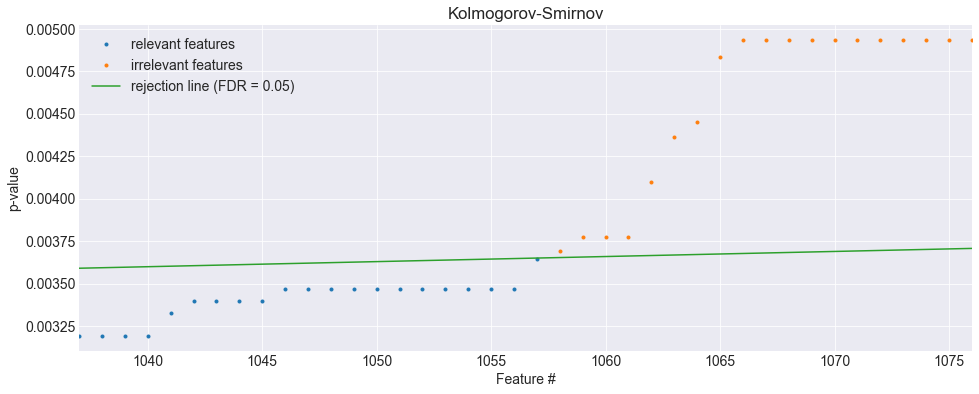

In [17]:
last_rejected_index = (df_pvalues_smir["rejected"] == True).sum() - 1
margin = 20
a = max(last_rejected_index - margin, 0)
b = min(last_rejected_index + margin, len(df_pvalues_smir) - 1)

df_pvalues_smir[a:b].p_value.where(df_pvalues_smir[a:b].rejected)\
    .plot(style=".", label="relevant features")
df_pvalues_smir[a:b].p_value.where(~df_pvalues_smir[a:b].rejected)\
    .plot(style=".", label="irrelevant features")
plt.plot(np.arange(a, b), rejection_line_smir[a:b], label="rejection line (FDR = " + str(FDR_LEVEL) + ")")
plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Kolmogorov-Smirnov")
plt.legend()
plt.plot()